In [88]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [60]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import copy
import os
import glob
import pylab as pl
import numpy as np
import matplotlib.animation as animation
import types
from mpl_toolkits.basemap import cm,addcyclic,Basemap, shiftgrid
import matplotlib.patches as patches
% matplotlib inline

In [61]:
from ArcticTools import hovmoller as hov
import seaborn as sn
sn.set()

In [62]:
nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y*2008*.nc'))#*_ptrc_T*.nc'))
print("found *.nc file: \n{}".format(nc_filename))
ptrc=nc.Dataset(nc_filename[0])

uvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridU_19692008.nc')

vvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridV_19692008.nc')

wvel=nc.Dataset('/ocean/xiaoxiny/research/result_jasper/data_eng3/ANHA4-ENG3_gridW_19692008.nc')

found *.nc file: 
['/ocean/xiaoxiny/research/result_jasper/min_ice/nasaRun/Y19682008.nc']


In [63]:
nav_lon=ptrc.variables['nav_lon'][:,:]
nav_lat=ptrc.variables['nav_lat'][:,:]
dep = ptrc.variables['deptht'][:]


tmask=nc.Dataset(
        '/ocean/xiaoxiny/research/NEMO-code/NEMOGCM/CONFIG/myANHA/EXP00/crop.nc')
#mbathy=tmask.variables['mbathy'][0,400:,:]
e1t=tmask.variables['e1t'][0,400:,:]
e2t=tmask.variables['e2t'][0,400:,:]
e3t=tmask.variables['e3t'][0,:,400:,:]
tmask=tmask.variables['tmask'][0,:,400:,:]


bathy=nc.Dataset(
    '/ocean/xiaoxiny/research/data/Jasper/ANHA4_bathy_etopo1_gebco1_smoothed_coast_corrected_mar10.nc')
bathy=bathy.variables['Bathymetry'][400:,:]



In [64]:
def vel(keyword,T,ENG):
    'design to obtain velocity field'
    if keyword =='U':
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*U*%s*.nc'%(ENG,T)))
        uvel=nc.Dataset(nc_filename[0])        
        data =uvel.variables['vozocrtx'][0,:,400:,:]
    else:
        nc_filename=sorted(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*V*%s*.nc'%(ENG,T)))
        vvel=nc.Dataset(nc_filename[0])
        data =vvel.variables['vomecrty'][0,:,400:,:]
    data =np.ma.masked_where(tmask==0,data)
    return data

In [65]:
m = Basemap(projection='npstere',boundinglat=67,lon_0=0,resolution='l',round='TRUE')
x_lon,y_lat = m(nav_lon,nav_lat)

In [66]:
def Fram(year,ENG='exh001'):
    fig = plt.figure(figsize=(10,3))
    temp= hov.load_ts('T',T=year,tmask= tmask, ENG='exh001', key = '_t_')
    sal= hov.load_ts('S',T=year,tmask= tmask, ENG='exh001', key = '_s_')
    plt.subplot(121)
    plt.pcolor(nav_lon[-265,310:335],dep[:],np.ma.masked_invalid(temp[:,-265,310:335]),\
               cmap='Spectral_r');
    plt.colorbar()
    plt.ylim([0,1500]);plt.gca().invert_yaxis();
    plt.xlabel('x (km)');plt.ylabel('depth (m)')
    
    plt.subplot(122)
    plt.pcolor(nav_lon[-265,310:335],dep[:],np.ma.masked_invalid(sal[:,-265,310:335]),\
               cmap='Spectral_r');
    plt.colorbar();plt.ylim([0,1500])
    plt.gca().invert_yaxis();
    plt.xlabel('x (km)');plt.ylabel('depth (m)')

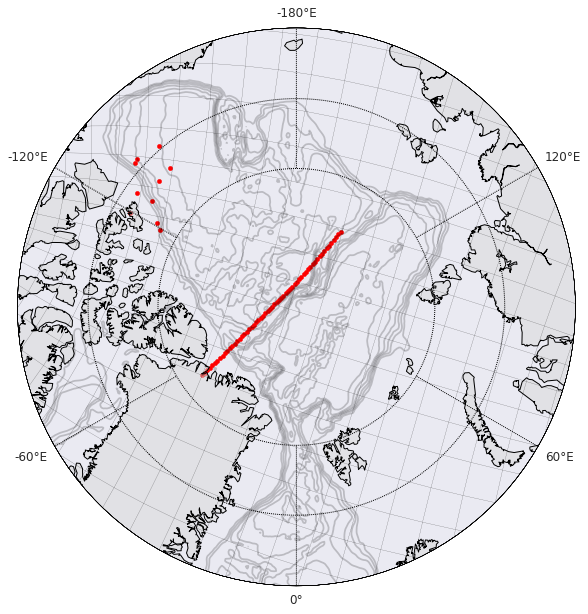

In [67]:
fig = plt.figure(figsize = (10,10))
m,x_lon,y_lat = hov.mapping(70)

a= [-260] 
b= [260]

for i in range (1,60):
    a.append(a[i-1]+2)
    b.append(b[i-1]+1)
m.scatter(x_lon[a,b],y_lat[a,b],color='r')

xCB= np.random.randint(630-400,700-400,10)
yCB= np.random.randint(170,200,10)
m.scatter(x_lon[xCB,yCB],y_lat[xCB,yCB],color='r')

In [68]:
xCB,yCB

(array([254, 275, 235, 275, 230, 238, 250, 265, 278, 288]),
 array([177, 198, 196, 173, 199, 175, 189, 192, 174, 189]))

In [69]:
def load_v(vel_comp,T, tmask, ENG, key ):
    '''
    This function is designed to obtain velocity field
    ======================================================
    '''
    vels ={'U':'vozocrtx','V':'vomecrty','W':'vovecrtz'}

    with nc.Dataset(glob.glob('/ocean/xiaoxiny/research/result_jasper/data_eng3/*%s*%s*%s.nc'%(ENG,vel_comp,T))[0])\
as temp:
        data  = temp.variables[vels[vel_comp]][0,:,400:,:]
    #data  = np.ma.masked_where(tmask == 0,data)
    return data

In [70]:
# grid for plotting
x1d=np.linspace(0,nav_lon[:,0].shape[0],nav_lat[:,0].shape[0])
y1d=np.linspace(0,nav_lon[0,:].shape[0],nav_lat[0,:].shape[0])
x2d,y2d=np.meshgrid(y1d,x1d)

In [71]:
def velField(year, layer,ENG='EXH001'):
    fig = plt.figure(figsize=(10,10))
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')

    Q=plt.quiver(x2d[::4,::4], y2d[::4,::4], np.mean(e3t[:layer,::4,::4]*u[:layer,::4,::4],axis=0), \
                 np.mean(e3t[:layer,::4,::4]* v[:layer,::4,::4],axis=0),
               scale=5.,width=0.0025,color='k',alpha=0.7)
    Qlabel=plt.quiverkey(Q,0.1, 0.05, 0.05, '0.05 m/s',fontproperties={'weight': 'bold'})

    plt.contour(bathy,linewidth=0.075,colors='black',alpha=0.4)
    plt.ylim(115,350)    
    plt.xlim(100,400)
    plt.title(year)
    return fig

# find a session on LR 

(Difference with the previous one: vector scale is changed.)

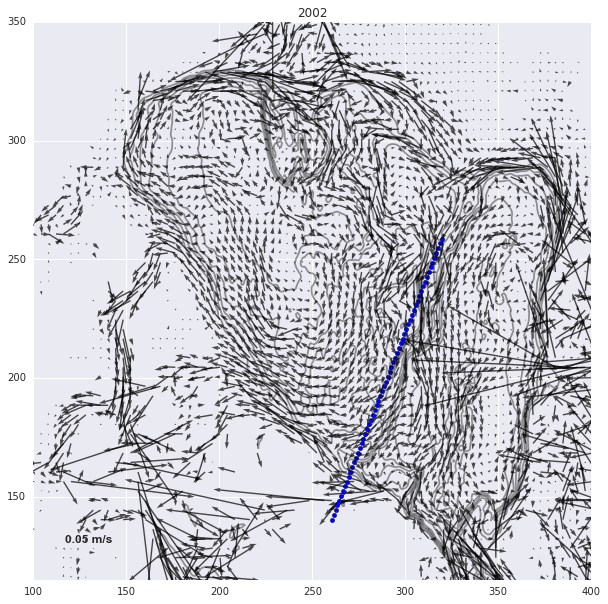

In [72]:
fig= velField(year=2002, layer=24,ENG='EXH001')
plt.scatter(x2d[a,b], y2d[a,b])

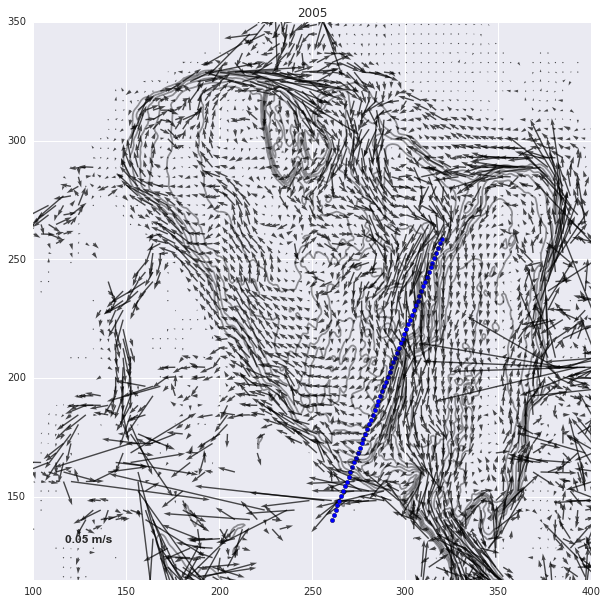

In [73]:
velField(year=2005, layer=24,ENG='EXH005')
plt.scatter(x2d[a,b], y2d[a,b])

In [74]:
def find_vel(yearnum,startyear,ENG):
    
    Fram_influx=[]
    Bsea_influx=[]
    year=[]
    a=[];b=[]
    
    vel_= {'u15':[],'u25':[],'u30':[],'u35':[], 'u39':[]}
    vkey={'u15':15,'u25':25, 'u30':30, 'u35':35 , 'u39':39}
    
    for time in range (yearnum):

        # loading vel
        u =vel('U',time+startyear,ENG)
        v =vel('V',time+startyear,ENG)
        aindex=325
        bindex=200
        for i,vlayer in zip (vel_.keys(),vkey.keys()):
            vel_[i].append(np.nanmean(v[vkey[vlayer],xCB,yCB]*np.cos(45)-u[vkey[vlayer],xCB,yCB]*np.sin(45))) 
        year.append(time+startyear)

    return np.array(year),vel_

# EXH001 

Orange: flux cross LR
Blue&Green: velocity at scatter points (will change to Topostrophy latter)

In [85]:
# find vel
Year, vel_=\
find_vel(yearnum=12,startyear=2002,ENG='EXH001')

In [76]:
layer = 24

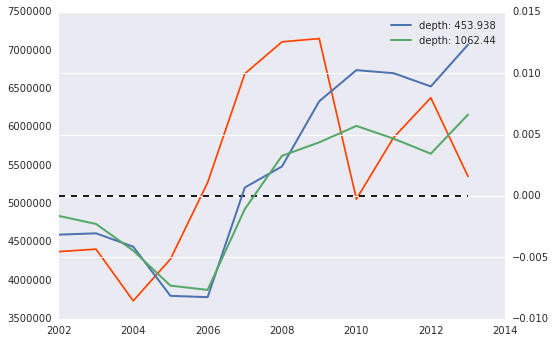

In [77]:
# find flux
Flux=[]
for year in range (2002,2014):
    v= load_v('V',T=year,tmask= tmask, ENG='EXH001', key = 'V')
    u= load_v('U',T=year,tmask= tmask, ENG='EXH001', key = 'U')
    
    z= (1.5**2+1**2)**0.5
    
    rotav = v * 1/z+ u * 2/z 
    dsec  = ((e2t * 2)**2 + (e1t * 1)**2)**0.5
    flux = 0
    for num in range(layer):
        flux += rotav[num,a,b] * dsec[a,b] *e3t[num,a,b]
    flux[flux > 0] = np.nan
    Flux.append(flux)

# plot
fig, ax1 = plt.subplots()
ax1.plot(Year,-np.nansum(np.array(Flux),axis=1),c='orangered',label='flux - cross-LomonsovR')
ax1.grid(False)
#ax1.set_ylim(8e5,13e5)

ax2 = ax1.twinx()        
ax2.plot(Year,np.ma.masked_invalid(vel_['u30'][:]),lw=2,label='depth: %s'%dep[30])
ax2.plot(Year,np.ma.masked_invalid(vel_['u35'][:]),lw=2,label='depth: %s'%dep[35])
ax2.hlines(y=0,xmin=np.min(Year),xmax=np.max(Year),linestyles='--')
plt.legend()

# EXH005

In [78]:
Year, vel_=\
find_vel(yearnum=12,startyear=2002,ENG='EXH005')

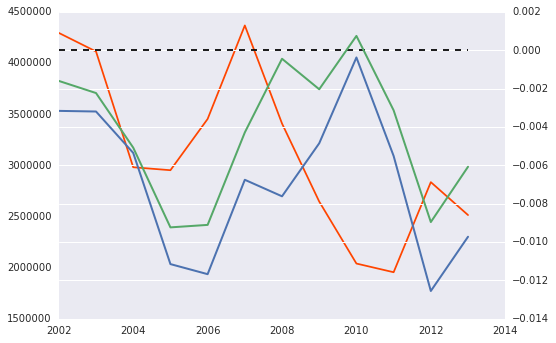

In [79]:
# find flux
FluxEXH005=[]

for year in range (2002,2014):
    v= load_v('V',T=year,tmask= tmask, ENG='EXH005', key = 'V')
    u= load_v('U',T=year,tmask= tmask, ENG='EXH005', key = 'U')
    
    z= (1.5**2+1**2)**0.5
    
    rotav = v * 1/z+ u * 2/z 
    dsec  = ((e2t * 2)**2 + (e1t * 1)**2)**0.5
    flux = 0
    for num in range(layer):
        flux += rotav[num,a,b] * dsec[a,b] *e3t[num,a,b]
    flux[flux > 0] = np.nan
    FluxEXH005.append(flux)

# plot
fig, ax1 = plt.subplots()
ax1.plot(Year,-np.nansum(np.array(FluxEXH005),axis=1),c='orangered',label='flux - cross-LomonsovR') 
ax1.grid(False)
#ax1.set_ylim(4.5e5,10.5e5)

ax2 = ax1.twinx()        
ax2.plot(Year,np.ma.masked_invalid(vel_['u30'][:]),lw=2,label='depth: %s'%dep[30])
ax2.plot(Year,np.ma.masked_invalid(vel_['u35'][:]),lw=2,label='depth: %s'%dep[35])
ax2.hlines(y=0,xmin=np.min(Year),xmax=np.max(Year),linestyles='--')

# Difference between TPD flux in two runs

Long term trend is different but short term trend is similar..

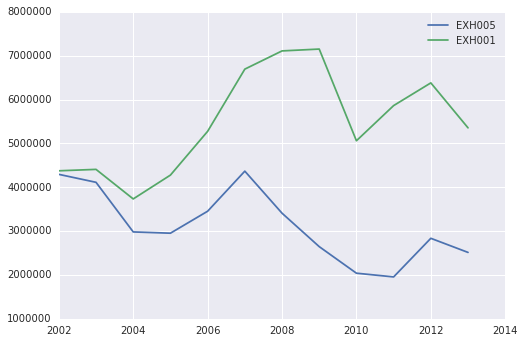

In [86]:
fig, ax1 = plt.subplots()
ax1.plot(Year,-np.nansum(np.array(FluxEXH005),axis=1),label='EXH005') 
ax1.plot(Year,-np.nansum(np.array(Flux),axis=1),label='EXH001') 
plt.legend()

# ENG3

In [81]:
Year, vel_=\
find_vel(yearnum=50,startyear=1958,ENG='ENG3')

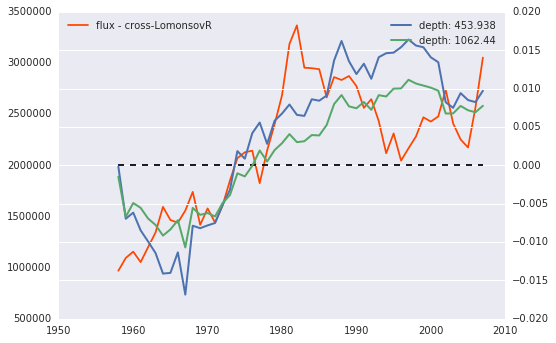

In [82]:
Flux=[]
for year in range (1958,2008):
    v= load_v('V',T=year,tmask= tmask, ENG='ENG3', key = 'V')
    u= load_v('U',T=year,tmask= tmask, ENG='ENG3', key = 'U')
    
    z= 1.5**2+1**2
    
    totv = v * 1/z+ u * 1.5/z 
    dsec  = ((e2t * 1)**2 + (e1t * 1.5)**2)**0.5
    flux = 0
    for num in range(layer):
        flux += totv[num,a,b] * dsec[a,b] *e3t[num,a,b]
    flux[flux > 0] = np.nan
    Flux.append(flux)

# plot
fig, ax1 = plt.subplots()
ax1.plot(Year,-np.nansum(np.array(Flux),axis=1),c='orangered',label='flux - cross-LomonsovR') 
ax1.legend(loc=2)
ax1.grid(False)
#ax1.set_ylim(4.5e5,10.5e5)

ax2 = ax1.twinx()        
ax2.plot(Year,np.ma.masked_invalid(vel_['u30'][:]),lw=2,label='depth: %s'%dep[30])
ax2.plot(Year,np.ma.masked_invalid(vel_['u35'][:]),lw=2,label='depth: %s'%dep[35])
ax2.hlines(y=0,xmin=np.min(Year),xmax=np.max(Year),linestyles='--')
ax2.legend(loc=1)